In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import math
import json

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from itertools import product

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.markers as ma
import seaborn as sns

/Users/amandaquay/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")

In [4]:
tf.Session(config=tf.ConfigProto(log_device_placement=True))

## Data

In [24]:
# r'Users/amandaquay/Box\ Sync/90904_FinalProject/SanJoaquinSalinityML/
pathway = 'data_average_after.csv'
df = pd.read_csv(pathway, index_col=0).dropna()
df = df.sort_values(by=['Field_ID']).sort_values(by=['Field_ID'])

# NDVI = (NIR-R)/(NIR+R)
df['NDVI'] = ((df['band_4_mean_2013'] - df['band_3_mean_2013'])/(df['band_4_mean_2013'] + df['band_3_mean_2013']))
# SI = sqrt(G*R)
df['SI'] = np.sqrt(df['band_2_mean_2013'] * df['band_3_mean_2013'])
# SI3 = sqrt(G^2 + R^2)
df['SI3'] = np.sqrt((df['band_2_mean_2013']**2) + (df['band_3_mean_2013']**2))
# SRSI = sqrt((NDVI-1)^2 + SI^2)
df['SRSI'] = np.sqrt(((df['NDVI']-1)**2) + (df['SI']**2))
# extract independent variables of use
df_small = df[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
               'slope', 'average_temperature', 'total_precipitation',
              'band_1_mean_2013', 'band_5_mean_2013', 'band_7_mean_2013',
              'SI', 'SI3', 'SRSI']]

df_small.head()
df_original_small = df[df.Field_ID != 20.0]
df_original_small = df_original_small[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
               'slope', 'average_temperature', 'total_precipitation']]

In [7]:
df_small_outlier_removed = df_small[df_small.Field_ID != 20.0]

In [8]:
df_fully_clean = df[df.Field_ID != 20.0]
df_fully_clean_keepexplore = df_fully_clean
df_fully_clean = df_fully_clean[df_fully_clean.Field_ID != 2.0]
df_fully_clean = df_fully_clean[df_fully_clean.Field_ID != 19.0]
df_fully_clean_keepexplore = df_fully_clean_keepexplore[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
               'slope', 'average_temperature', 'total_precipitation',
              'band_1_mean_2013', 'band_5_mean_2013', 'band_7_mean_2013',
              'SI', 'SI3', 'SRSI']]
df_small_fully_clean = df_fully_clean[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
               'slope', 'average_temperature', 'total_precipitation',
              'band_1_mean_2013', 'band_5_mean_2013', 'band_7_mean_2013',
              'SI', 'SI3', 'SRSI']]
df_small_fully_clean.head()

,salinity,Field_ID,max_CRSI,elevation,aspect,slope,average_temperature,total_precipitation,band_1_mean_2013,band_5_mean_2013,band_7_mean_2013,SI,SI3,SRSI
0,0.010,1.0,0.774290,66,328,1,285.08047,119.0,1073.947368,3852.157895,3011.578947,1564.123572,2235.189855,1564.123768
2,3.827,1.0,0.781937,66,152,0,285.08047,119.0,1084.421053,3969.842105,3067.526316,1561.267704,2233.854531,1561.267898
3,3.080,1.0,0.775323,66,151,0,285.08047,119.0,1070.052632,3903.947368,3028.105263,1541.991441,2203.890990,1541.991638
4,1.092,1.0,0.766537,66,149,0,285.08047,119.0,1104.210526,3963.105263,3104.421053,1601.853506,2290.493941,1601.853697
5,0.146,1.0,0.748702,66,148,0,285.08047,119.0,1103.315789,3925.263158,3061.631579,1622.594409,2321.591853,1622.594597


## Functions

In [9]:
def plot_actual_vs_predicted(actual, predicted, ylim=(0,40), xlim=(0,40)):
    plt.scatter(actual, predicted, s=5, alpha = 0.3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot((0,40),(0,40), linewidth=2, color='black')
    plt.xlabel('Actual Salinity (dS/m)')
    plt.ylabel('Predicted Salinity (dS/m)')
    plt.show()

In [10]:
def plot_actual_vs_predicted_fields(actual, predicted, field_list, in_ylim=(0,40), in_xlim=(0,40)):
    field_dict = { 1.0:[179,0,0],  2.0:[255,51,51],  3.0:[255,153,153],  4.0:[255,133,51],  5.0:[255,179,102],
              6.0:[255,255,26],  7.0:[172,230,0],  8.0:[115,153,0],  9.0:[0,102,34], 10.0:[0,204,102],
             11.0:[0,230,184], 12.0:[102,194,255], 13.0:[0,57,230], 14.0:[153,153,255], 15.0:[255,153,255],
             16.0:[204,0,204], 17.0:[122,0,204], 18.0:[191,128,64], 19.0:[102,51,0], 20.0:[0,0,0],
             21.0:[115,115,115], 22.0:[217,217,217]}
    # normalize this ish
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim(in_xlim)
    plt.ylim(in_ylim)
    plt.tick_params(labelsize = 18)
    plt.plot((0,40),(0,40), linewidth=2, color='black')
    plt.xlabel('Actual Salinity (dS/m)', fontsize = 20)
    plt.ylabel('Predicted Salinity (dS/m)', fontsize = 20)
    for k, val in field_dict.items():
        for i in range(3): # normalize the RGB values so that matplotlib will allow as input
            field_dict[k][i] = field_dict[k][i]/255.0 
        # find all rows from same field, add to temp lists, and plot them
        temp_y = []
        temp_y_hat = []
        for i in range(len(field_list)): 
            if (k == field_list[i]):
                temp_y.append(actual[i])
                temp_y_hat.append(predicted[i])
        plt.scatter(temp_y, temp_y_hat, s = 5, c = val, label = k) # plot one field at a time to separate labels
    plt.legend(loc = 'upper left', bbox_to_anchor=(1,1), ncol = 2)
    ax.legend(markerscale=4, loc = 'upper left', bbox_to_anchor = (1,1), ncol = 2)
    plt.show()

In [11]:
def train_test_split_lofo(df, drop_columns, test_field=None):
    fields = df['Field_ID'].unique()
    if test_field is None: test_field = np.array([np.random.choice(fields)])
    else: test_field=np.array([test_field])
    train_fields = np.setdiff1d(fields, test_field)

    test_field_indices = np.where(df['Field_ID'].isin(test_field))[0]
    train_field_indices = np.where(df['Field_ID'].isin(train_fields))[0]

    y = df['salinity'].values.reshape(-1,1)
    X = df.drop(df.columns[drop_columns], axis=1).values

    y_train = y[train_field_indices].ravel()
    y_test = y[test_field_indices].ravel()
    X_train = X[train_field_indices]
    X_test = X[test_field_indices]

    return X_train, y_train, X_test, y_test

In [12]:
def cross_validate_lofo(df, drop_columns, train_model_func, reg=0.0, keras=True): 
    y_hat = np.array([])
    fields = df['Field_ID'].unique()
    
    for field in fields:
        X_train, y_train, X_test, y_test = train_test_split_lofo(df, drop_columns, field)
        X_train, X_test = normalize_X(X_train, X_test)
        model = train_model_func(X_train, y_train, X_test, y_test, reg=reg, verbose=0)
        y_hat = np.append(y_hat, model.predict(X_test))
    
    y = df['salinity']
    mse = mean_squared_error(y, y_hat)
    return y_hat, mse

In [13]:
def normalize_X(X_train, X_test):
    x_max = np.max(X_train, axis=0, keepdims=True)
    x_min = np.min(X_train, axis=0, keepdims=True)
    range_x = x_max-x_min
    range_x[range_x==0] = 1
    x_min[range_x==0] = 0
    X_train = (X_train - x_min) / range_x
    X_test = (X_test - x_min) / range_x
    return X_train, X_test

In [14]:
def train_model(X_train, y_train, X_test, y_test, reg, **kwargs):
    model = Sequential([
        Dense(32, input_shape=(X_train.shape[1],), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg)),
        Activation('elu'),
        Dense(32, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg)),
        Activation('elu'),
        Dense(1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg))
    ])
    opt = optimizers.adam()
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.fit(X_train,y_train, epochs=30, batch_size=32, validation_data=(X_test,y_test), **kwargs)
    return model

## Neural Net

In [15]:
## Define X and y
y = df_small['salinity'].values
drop_columns = [0,1]
X = df_small.drop(df_small.columns[drop_columns], axis=1).values

In [17]:
X_train, y_train, X_test, y_test = train_test_split_lofo(df_small, drop_columns)
X_train, X_test = normalize_X(X_train, X_test)

In [21]:
%%time
y_hat, mse = cross_validate_lofo(df_small, drop_columns, train_model_func=train_model)

CPU times: user 5min 20s, sys: 2min 5s, total: 7min 26s
Wall time: 7min 8s


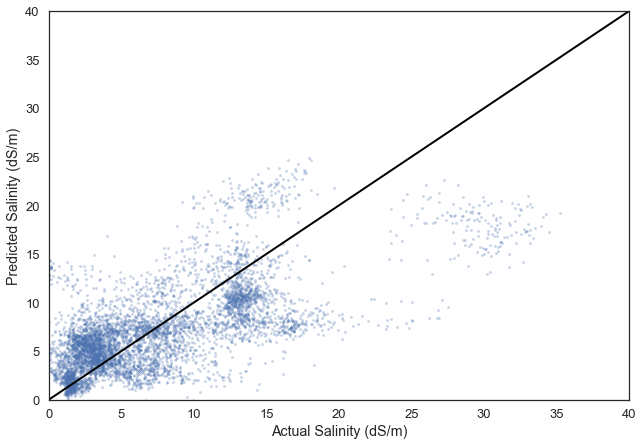

In [26]:
plot_actual_vs_predicted(y, y_hat)

In [23]:
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 3.36
MSE: 20.76
R_squared: 0.45


## Neural Net: Original Features, Outlier Field Removed

In [25]:
## Define X and y
y = df_original_small['salinity'].values
drop_columns = [0,1]
X = df_original_small.drop(df_original_small.columns[drop_columns], axis=1).values

In [27]:
X_train, y_train, X_test, y_test = train_test_split_lofo(df_original_small, drop_columns)
X_train, X_test = normalize_X(X_train, X_test)

In [28]:
%%time
y_hat, mse = cross_validate_lofo(df_original_small, drop_columns, train_model_func=train_model)

CPU times: user 4min 50s, sys: 2min 6s, total: 6min 56s
Wall time: 5min 20s


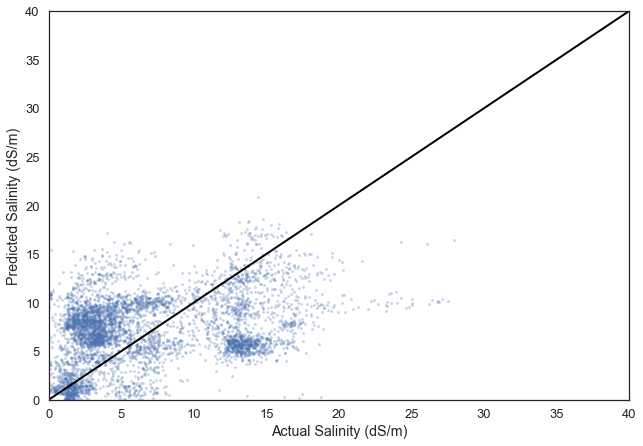

In [29]:
plot_actual_vs_predicted(y, y_hat)

In [30]:
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 5.16
MSE: 41.50
R_squared: -0.65


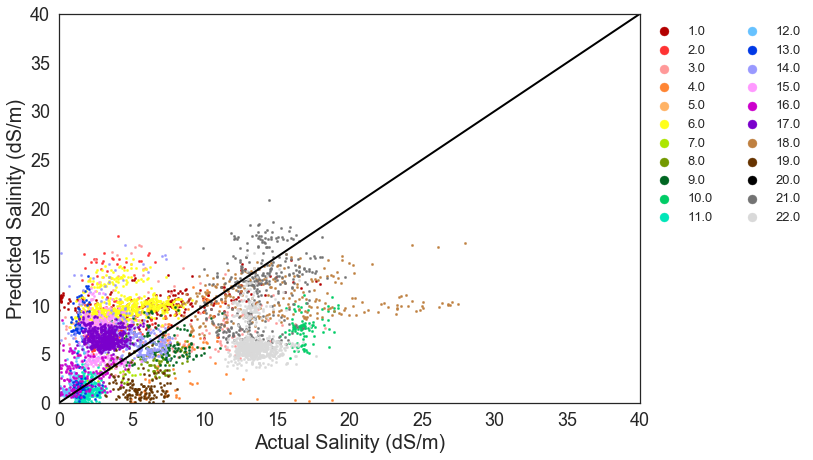

In [32]:
field_list = df_original_small['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list)

## Neural Net: Removed Outlier Field

In [28]:
## Define X and y
y = df_small_outlier_removed['salinity'].values
drop_columns = [0,1]
X = df_small_outlier_removed.drop(df_small_outlier_removed.columns[drop_columns], axis=1).values

In [29]:
X_train, y_train, X_test, y_test = train_test_split_lofo(df_small_outlier_removed, drop_columns)
X_train, X_test = normalize_X(X_train, X_test)

In [33]:
%%time
y_hat, mse = cross_validate_lofo(df_small_outlier_removed, drop_columns, train_model_func=train_model)

CPU times: user 7min 4s, sys: 2min 1s, total: 9min 5s
Wall time: 10min 18s


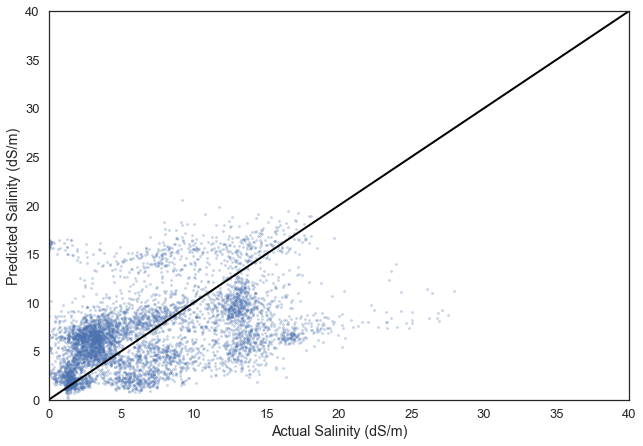

In [34]:
plot_actual_vs_predicted(y, y_hat)

In [35]:
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 3.66
MSE: 22.03
R_squared: 0.12


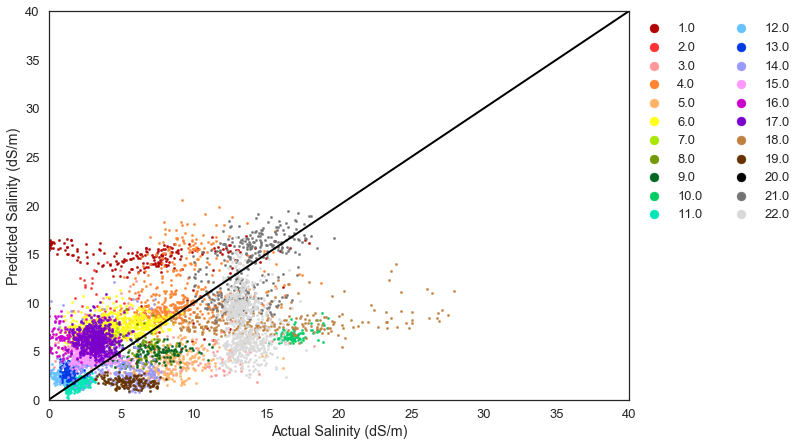

In [59]:
field_list = df_small_outlier_removed['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list)

## Neural Net: Removed Outlier Field (#20) 

In [17]:
## Define X and y
y = df_fully_clean_keepexplore['salinity'].values
drop_columns = [0,1]
X = df_fully_clean_keepexplore.drop(df_fully_clean_keepexplore.columns[drop_columns], axis=1).values

In [18]:
X_train, y_train, X_test, y_test = train_test_split_lofo(df_fully_clean_keepexplore, drop_columns)
X_train, X_test = normalize_X(X_train, X_test)

In [19]:
%%time
y_hat, mse = cross_validate_lofo(df_fully_clean_keepexplore, drop_columns, train_model_func=train_model)

CPU times: user 3min 49s, sys: 2min 8s, total: 5min 57s
Wall time: 4min 10s


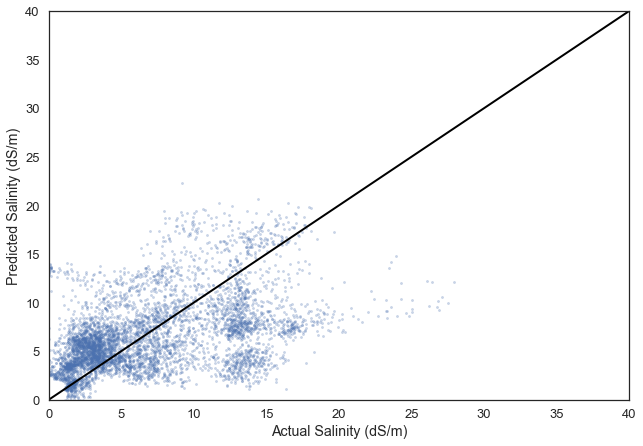

In [20]:
plot_actual_vs_predicted(y, y_hat)

In [21]:
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 3.57
MSE: 21.94
R_squared: 0.13


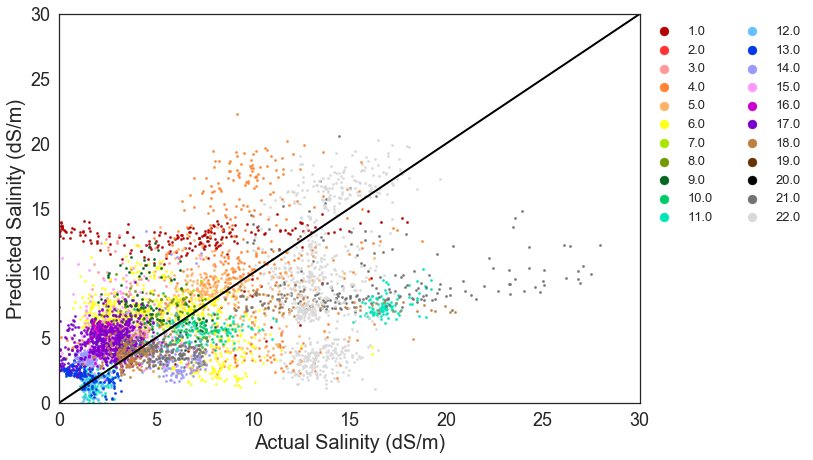

In [22]:
field_list = df_small_fully_clean['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list, in_ylim=(0,30), in_xlim=(0,30))

## Neural Net: Removed Outlier Field (#20) and Explore Fields (#2, #19)

In [61]:
## Define X and y
y = df_small_fully_clean['salinity'].values
drop_columns = [0,1]
X = df_small_fully_clean.drop(df_small_fully_clean.columns[drop_columns], axis=1).values

In [62]:
X_train, y_train, X_test, y_test = train_test_split_lofo(df_small_fully_clean, drop_columns)
X_train, X_test = normalize_X(X_train, X_test)

In [63]:
%%time
y_hat, mse = cross_validate_lofo(df_small_fully_clean, drop_columns, train_model_func=train_model)

CPU times: user 6min 16s, sys: 1min 43s, total: 8min
Wall time: 8min 18s


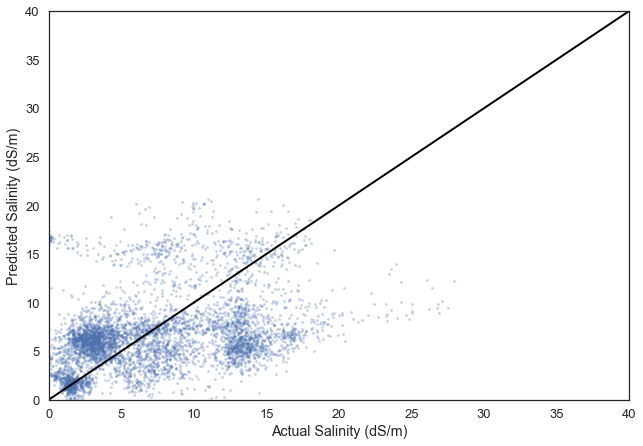

In [64]:
plot_actual_vs_predicted(y, y_hat)

In [65]:
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 3.94
MSE: 26.04
R_squared: -0.00


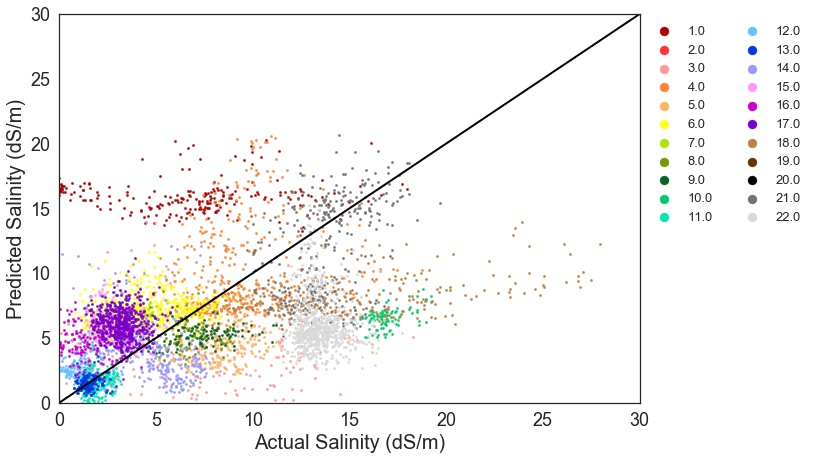

In [68]:
field_list = df_small_fully_clean['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list, in_ylim=(0,30), in_xlim=(0,30))

## Grid Search 
#### Using a regularizer (L2)

In [73]:
reg_list = np.arange(0.0, 0.25, 0.025)
reg_list = np.append(reg_list, 0.5)
reg_list = np.append(reg_list, 3.0)
reg_list = np.append(reg_list, 5.0)
reg_list

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.5  , 3.   , 5.   ])

In [75]:
%%time
predicted_list = []
mse_list = []

for reg in reg_list:
    print("Working on:\t" + str(reg))
    y_hat, mse = cross_validate_lofo(df_small_fully_clean, drop_columns, train_model_func=train_model, reg= reg)
    predicted_list.append(y_hat)
    mse_list.append(mse)
    print("\t\tMSE:" +str(mse))

Working on:	0.0
		MSE:22.037152161694312
Working on:	0.025
		MSE:17.592394113385282
Working on:	0.05
		MSE:18.169939841188913
Working on:	0.07500000000000001
		MSE:20.08610267410984
Working on:	0.1
		MSE:20.12611870159087
Working on:	0.125
		MSE:23.021065559350227
Working on:	0.15000000000000002
		MSE:22.08025183611524
Working on:	0.17500000000000002
		MSE:23.18059616041919
Working on:	0.2
		MSE:22.32512884179097
Working on:	0.225
		MSE:22.248437843615793
Working on:	0.5
		MSE:22.865554390118046
Working on:	3.0
		MSE:29.975808594241474
Working on:	5.0
		MSE:30.1857349734537
CPU times: user 2h 35min 40s, sys: 37min 30s, total: 3h 13min 11s
Wall time: 18h 43min 30s


In [76]:
best_index = np.argmin(mse_list)
y_hat = predicted_list[best_index]
mse = mse_list[best_index]

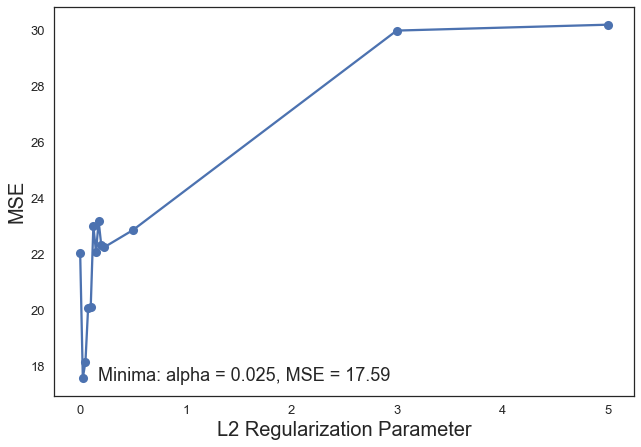

In [88]:
# Plot MSE vs. L2's alpha (regularization parameter)

plt.plot(reg_list, mse_list, '-o')
plt.text(0.17, 17.5, "Minima: alpha = 0.025, MSE = 17.59", fontsize = 18)
plt.xlabel('L2 Regularization Parameter', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.show()

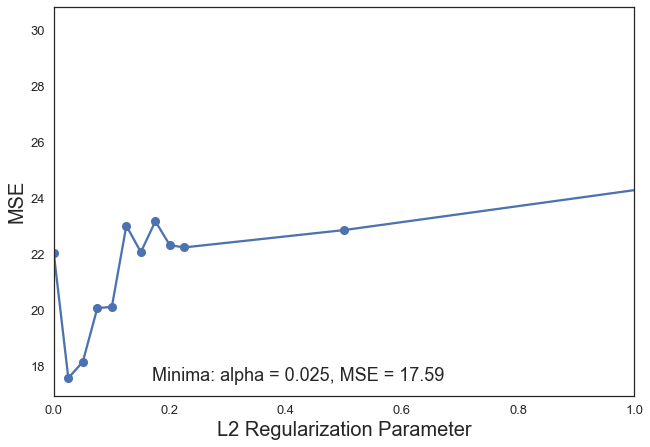

In [91]:
# Plot MSE vs. L2's alpha (regularization parameter)
plt.xlim(0,1)
plt.plot(reg_list, mse_list, '-o')
plt.text(0.17, 17.5, "Minima: alpha = 0.025, MSE = 17.59", fontsize = 18)
plt.xlabel('L2 Regularization Parameter', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.show()

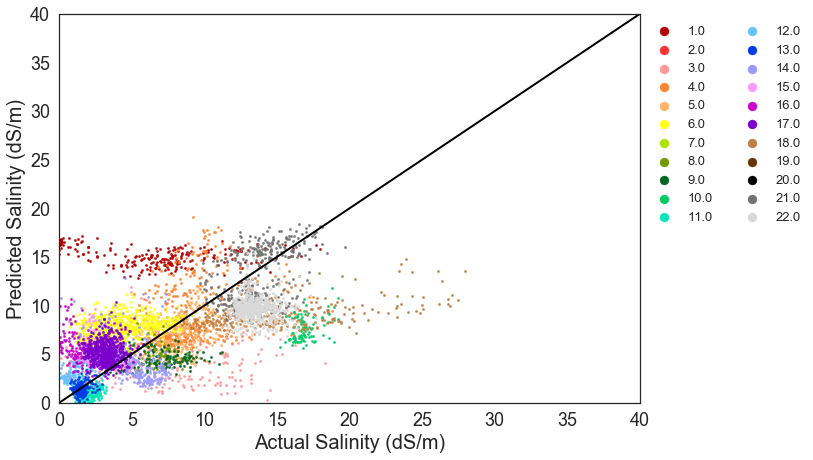

In [94]:
field_list = df_small_fully_clean['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list)

#### Ok, let's try to get the MSE and MAE for the 0.025 alpha. Perhaps fine-tuning would have helped get a better alpha (between 0 and 0.05), but we're out of time :(

In [33]:
## Define X and y
y = df_fully_clean_keepexplore['salinity'].values
drop_columns = [0,1]
X = df_fully_clean_keepexplore.drop(df_fully_clean_keepexplore.columns[drop_columns], axis=1).values

In [35]:
X_train, y_train, X_test, y_test = train_test_split_lofo(df_fully_clean_keepexplore, drop_columns)
X_train, X_test = normalize_X(X_train, X_test)

In [36]:
%%time
y_hat, mse = cross_validate_lofo(df_fully_clean_keepexplore, drop_columns, train_model_func=train_model, reg= 0.025)

CPU times: user 6min 29s, sys: 2min 54s, total: 9min 23s
Wall time: 8min 41s


In [37]:
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 3.16
MSE: 16.36
R_squared: 0.35


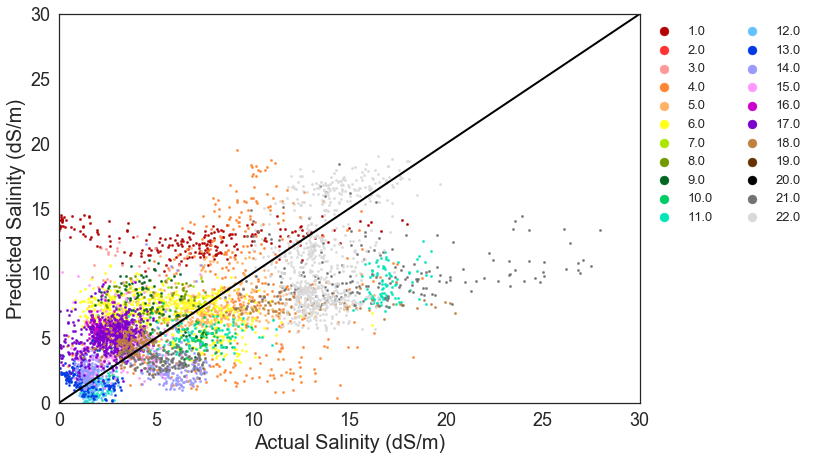

In [38]:
field_list = df_small_fully_clean['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list, in_ylim=(0,30), in_xlim=(0,30))

In [39]:
# Finished--out of time.